# Identifying Fraud in the Enron Dataset: Building a POI Classifier

## By Jacob Dodd

## Introduction

### Background

In 2000, Enron was one of the largest companies in the United States. By 2002, it had collapsed into bankruptcy due to widespread corporate fraud. As a result of the ensuing trial, many of the employees emails had their emails and financial information released. 

### Project Goal

This project seeks to classify former Enron employees as "Persons of Interest",or people that the authorities should interview in the investigation, based on the dataset described above. 

I will be using Python and Python's data analysis and machine learning libraries to accomplish this task. Python is a flexible, general purpose programming language with libraries that allow mining of all data, including text data, easy and efficient.

Machine learning is great for this task, as there are many strong classification algorithms that can seek patterns in the data that someone manually looking over might not, while being quicker as well.

This project was completed as part of my Data Analyst Nanodegree from Udacity. 

##### Full code is available at my github repo for the project: https://github.com/Jacobdudee/EnronModel/blob/master/

##### I hereby confirm that this submission is my work. I have cited above the origins of any parts of the submission that were taken from Websites, books, forums, blog posts, github repositories, etc.

In [117]:
import pickle as pkl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.lines as mlines

In [126]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pkl.load(data_file)

#pandas dataframe for exploration purposes
enron_df = pd.DataFrame.from_dict(data_dict,orient='index')

## Dataset Overview 

##### Features

There is a mix of email and financial features:

- <b/>'poi' [Target Variable]</b>
- 'salary'
- 'deferral_payments'
- 'total_payments' 
- 'loan_advances' 
- 'bonus'
-'restricted_stock_deferred'
- 'deferred_income'
- 'total_stock_value'
- 'expenses'
- 'exercised_stock_options'
- 'long_term_incentive'
- 'restricted_stock'
- 'director_fees'
- 'from_poi_to_this_person'
- 'from_this_person_to_poi'
- 'shared_receipt_with_poi'
- 'to_messages'
- 'from_messages'

Some features that caught my eye were messages to and from persons of interest, some features we could create are the percentage of emails to a person of interest and from a person of interest. 

##### Outlier Detection

There was one outlier, with the name "TOTAL". As the financial data comes from a spreadsheet, this was probably just some quirk. It was removed. 


In [127]:
### Task 2: Remove outliers
data_dict.pop("TOTAL")
enron_df = enron_df[enron_df.index != "TOTAL"]

##### Missing features

Let's take a look at the rate of non-null values for each feature:

In [128]:
for col in enron_df.columns:
    if str(enron_df[col].dtype) != 'bool':
        print col,(enron_df[enron_df[col] !='NaN'][col].count()) \
        ,round((enron_df[enron_df[col] !='NaN'][col].count())/ \
        (float(enron_df.shape[0])),2)

salary 94 0.65
to_messages 86 0.59
deferral_payments 38 0.26
total_payments 124 0.86
exercised_stock_options 101 0.7
bonus 81 0.56
restricted_stock 109 0.75
shared_receipt_with_poi 86 0.59
restricted_stock_deferred 17 0.12
total_stock_value 125 0.86
expenses 94 0.65
loan_advances 3 0.02
from_messages 86 0.59
other 92 0.63
from_this_person_to_poi 86 0.59
director_fees 16 0.11
deferred_income 48 0.33
long_term_incentive 65 0.45
email_address 111 0.77
from_poi_to_this_person 86 0.59


Many of the features here do have a lot of missing values (> 50%). 
Salary, to_messages, total_payments and total stock value are some of the more complete features.  

There are some features with almost no data, like loan_advances, or director_fees. In any case, data quality on this dataset is not close to perfect.

## Data Exploration

#### How many persons of interest are there in this dataset?

In [50]:
print("number of poi: {}".format(enron_df[enron_df['poi']==True]['poi'].count()))

number of poi: 18


#### how many people are there in this dataset?


In [22]:
print("Number of people: {}".format(len(data_dict.keys())))

Number of people: 145


#### how many features per person?

In [26]:
print("Number of features/person: {}".format(len(data_dict.values()[1])))

Number of features/person: 21


#### What is the relationship between salary and long term incentive?

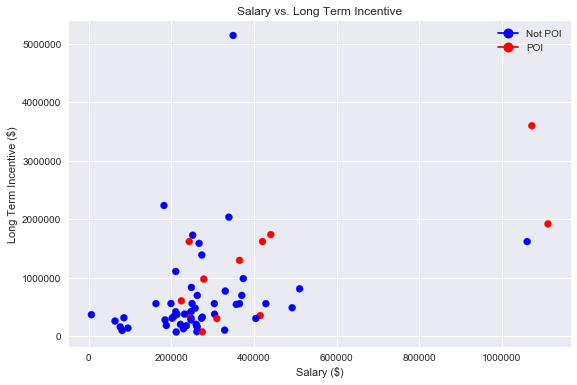

In [124]:
#creating plot
fig, ax = plt.subplots(1,1,figsize=(9,6))
c_map = {1: 'r', 0: 'b'}
ax.scatter(enron_df['salary'],enron_df['long_term_incentive'], 
           c=[c_map[i] for i in enron_df['poi']])
plt.ylabel("Long Term Incentive ($)")
plt.xlabel("Salary ($)")
plt.title("Salary vs. Long Term Incentive")

not_poi = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=10, label='Not POI')
poi = mlines.Line2D([], [], color='red', marker='o',
                          markersize=10, label='POI')
plt.legend(handles=[not_poi,poi])

plt.show()

## Pre-Processing and Feature Selection

### Feature Engineering

As discussed earlier in the overview section, I set out to create 2 new features:

1) perc_from_poi: the percentage of emails the person received from a poi

2) perc_to_poi: the percentage of emails the person sent to a poi

The logic behind these features is that POI could have sent a lot of communications between each other, discussing fraudulent activities. These features aim to quantify this in a generalizable way, hopefully having higher predictive power than a number of messages from a POI without the whole context. 
This was calculated by the following formulas:

- perc_from_poi =  from_poi_to_this_person/from_messages

- perc_to_poi =  to_poi_from_this_person/to_messages


In [51]:
# creating copy
my_dataset = data_dict

# creating new features
for key in my_dataset:
    empl = my_dataset[key]
    perc_to_poi, perc_from_poi = [] , []
    if (empl['from_this_person_to_poi'] != 'NaN') & (empl['from_messages'] != 'NaN'):
        perc_to_poi = float(empl['from_this_person_to_poi'])/float(empl['from_messages'])
        empl['perc_to_poi'] = perc_to_poi
    else:
        empl['perc_to_poi'] = 0
    
    if (empl['from_poi_to_this_person'] != 'NaN') & (empl['to_messages'] != 'NaN'):
        perc_to_poi = float(empl['from_poi_to_this_person'])/float(empl['to_messages'])
        empl['perc_from_poi'] = perc_to_poi
    else:
        empl['perc_from_poi'] = 0

### Feature Selection

Once these 2 new features were added to our data, we now had 23 features. With the low number of POI in the dataset (18 out of 145, ~12%), creating a model with all 23 features is ripe for overfitting. One way to describe overfitting is it is when the model picks up on noise in the dataset when trained, so when introduced to new information it loses predictive power. When a model has a larger number of features, there is bound to be more noise. Thus, we need to reduce the number of features in the dataset, which in turn will reduce the potential for overfitting.

To accomplish this with this dataset, I will use the k-best object from scikit-learn's pre-processing module. This class scores your dataset's features and allows you to select the k best number of features. In this case, I will select the top 10 features. 

In [103]:
#from feature_format import featureFormat, targetFeatureSplit
from sklearn.feature_selection import SelectKBest

In [101]:
#Select 10 best features using k-best
k_best = SelectKBest(k=11)
k_best.fit(features, labels )

##### SelectKBest Feature Importances

In [ ]:
9     exercised_stock_options  25.097542
7           total_stock_value  24.467654
4                       bonus  21.060002
0                      salary  18.575703
19                perc_to_poi  16.641707
6             deferred_income  11.595548
10        long_term_incentive  10.072455
11           restricted_stock   9.346701
2              total_payments   8.866722
15    shared_receipt_with_poi   8.746486
3               loan_advances   7.242730
8                    expenses   6.234201
13    from_poi_to_this_person   5.344942
18              perc_from_poi   3.210762
14    from_this_person_to_poi   2.426508
12              director_fees   2.107656
16                to_messages   1.698824
1           deferral_payments   0.217059
17              from_messages   0.164164
5   restricted_stock_deferred   0.064984

The strongest features were exerscised stock options, total stock value, bonus, salary, and percentage of emails to poi. 

#### Features Used
The following features were selected by kbest:

In [110]:
kbest_features = ['poi','deferral_payments', 'total_payments', 'loan_advances', 
                  'restricted_stock_deferred', 'deferred_income', 'expenses', 
                  'exercised_stock_options', 'long_term_incentive',
                  'from_this_person_to_poi', 'perc_from_poi']
print(kbest_features[1:])

['deferral_payments', 'total_payments', 'loan_advances', 'restricted_stock_deferred', 'deferred_income', 'expenses', 'exercised_stock_options', 'long_term_incentive', 'from_this_person_to_poi', 'perc_from_poi']


## Modeling

### Methodology

##### Hyperparameter tuning
Hyperparameters are the different knobs you can turn for a machine learning algorithm. 

Some models, like a Decision Tree or AdaBoost, have many hyperparameters that you can tune. Others, like a gaussian naive bayes model, do not.
Tuning can be done either programmatically, with the assistance of a grid search, or manually, passing arguments when creating the initial model object. 

Tuning is very important, as when done badly it you can end up with a model that overfits. As a reminder, overfitting is when the model learns from the noise in the data, so when shown new data, it loses predictive power. 

Grid search is a very powerful method, as it systematically works through multiple combinations of parameter tunes, cross-validating as it goes to determine which tune gives the best performance.

Each model used in this project, with the exception of the gaussian naive bayes, had hyperparamters programmatically tuned by a gridsearch, optimized for recall. 

##### Model Evaluation
When building a classification model, accuracy may not always be the best metric to use when validating a model, especially if you have an imbalanced target class. In this case, we do have an imbalanced target class, with only 18 poi out of 141 samples. This is where recall and precision come in. 

Recall is the probability that algorithm correctly ids class provided that the class is the predicted class, in this case classifies all poi's correctly. 
Precision is the rate of guessing the target class, given that it actually is the target class. In this case it is the rate of correctly guessing a poi. 

The goal of this project is to obtain a model with precision and recall metrics both above 0.3. 

##### Validation
Model validation is important, as when done right it prevents overfitting and more robust evaluation metrics. One way to do this for example, is to split the data into a train and test set. This ensures that you are holding out new data to test your model on. Another method is to randomly take k number of random of samples, train your model on each, and then average performance. This is k-fold cross validation. 

Due to the small size of the dataset (and target class), we want a strategy that makes the most of the data. This means the kfold strategy makes sense here. However, want to preserve the percentage of the target class as well, so there aren't any folds with 1 or 2 poi and some with 10. 

The script used in this project uses stratified shuffle split cross validation. This method accomplishes both the goals above, returning stratified randomized folds, while preserving the percentage of samples for each class.

### Results

#### Best Model
The best results came from using an AdaBoost Classifier, with learning rate, algorithm, and number of estimators tuned by a gridsearch. The final hyperparameters were: 

    - a learning rate of 1 
    - 35 estimators
    - SAMME.R algorithm

    AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1,
              n_estimators=35, random_state=None)

    Accuracy: 0.88040	Precision: 0.56527	Recall: 0.44600	F1: 0.49860	F2: 0.46565
	Total predictions: 15000	True positives:  892	False positives:  686	False negatives: 1108	True negatives: 12314

With 88% accuracy, and precision and recall both above 0.3, we have a winner.

The model was right 88% of the time, and when it guessed someone was a person of interest, it was right slightly less than half the time (45%). It was better, however, at identifying non persons of interst, with correct negative predictions at 91.7%. 

If used, this model could predict whether someone isn't a POI at a much higher rate than predicting if someone is a POI. 

In [115]:
sensitivity = round(1 - (1108./(1108+12314)),3)
print('Rate Identified non-poi: ',sensitivity)

('Rate Identified non-poi: ', 0.917)


#### Other Models:

I tested 3 other models, each with the chosen 10 k-best features.

Initially I used a Gaussian Naive Bayes Model, but the precision and recall were too low for this exercise, barely missing the desired cutoff of 0.3:

    GaussianNB(priors=None)

	Accuracy: 0.79500	Precision: 0.29142	Recall: 0.37550	F1: 0.32816	F2: 0.35502
	Total predictions: 15000	True positives:  751	False positives: 1826	False negatives: 1249	True negatives: 11174


Next, I used a Random Forest Classifier. I tuned the max_depth, max_features, min_samples_split, and n_estimators by a gridsearch for recall. While the accuracy was higher than the Naive Bayes, it had less than great results for recall:

    RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                max_depth=15, max_features=5, max_leaf_nodes=None,
                min_impurity_split=1e-07, min_samples_leaf=1,
                min_samples_split=15, min_weight_fraction_leaf=0.0,
                n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
                verbose=0, warm_start=False)

    Accuracy: 0.86007	Precision: 0.43391	Recall: 0.16250	F1: 0.23645	F2: 0.18574
	Total predictions: 15000	True positives:  325	False positives:  424	False negatives: 1675	True negatives: 12576

I next used a Logistic Regression, tuned for C (the regularization parameter):

    LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
              intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
              penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
              verbose=0, warm_start=False)

	Accuracy: 0.67673	Precision: 0.07312	Recall: 0.12200	F1: 0.09144	F2: 0.10761
	Total predictions: 15000	True positives:  244	False positives: 3093	False negatives: 1756	True negatives: 9907

## Conclusion

An AdaBoost Classifier was built that was able to predict a person of interest in the Enron dataset, with 88% accuracy, 56.5% precision, and 44.6% recall.

We were able to predict whether an employee was a person of interest to an extent. The model was right 88% of the time, but when it guessed someone was a person of interest, it was right slightly less than half the time (45%). 

## References

Scikit learn documentation:
http://scikit-learn.org/

How to create a custom legend in matplotlib
https://matplotlib.org/users/legend_guide.html

Ideas for tuning a decision tree:
http://chrisstrelioff.ws/sandbox/2015/06/25/decision_trees_in_python_again_cross_validation.html

Some tips on how to tune gridsearch for scores from:
https://www.kaggle.com/kevinarvai/fine-tuning-a-classifier-in-scikit-learn

Documentary on Enron which provided backstory and useful information:
https://en.wikipedia.org/wiki/Enron:_The_Smartest_Guys_in_the_Room

Udacity's Data Analyst nanodegree program for supporting code and lessons:
https://www.udacity.com/course/data-analyst-nanodegree--nd002